# Second-order (power Doppler, functional) reconstruction

Simulate and reconstruct movement of scatterers via second-order "Power Doppler" functional ultrasound. 
Plane waves are sent into the sample at different angles, composed of randomly placed scatterers. 
Then some of the scatterers inside of an inclusion are moved with Brownian noise. Repeating this process,
we obtain 50 reconstructions. The moving scatterers are invisible to a single structural reconstruction. However they
heavily change the speckle pattern of the ultrasound, which means a second-order reconstruction (looking at the variance of the signal over time)
shows the inclusion clearly.

(-10.394999999999998,
 10.394999999999998,
 36.74584974374656,
 -1.7498023687498365)

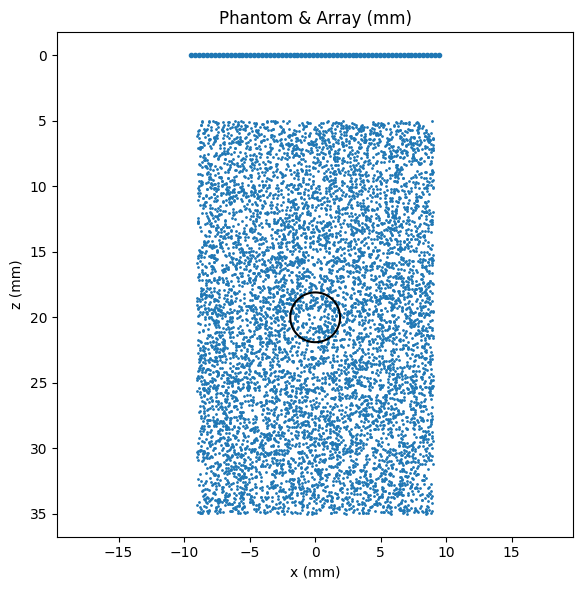

In [1]:
import numpy as np
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Tuple
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

import numpy as np
from typing import Sequence, Tuple, Optional, Literal
from dataclasses import dataclass
from scipy.interpolate import interp1d
from tqdm import tqdm

import numpy as np
from dataclasses import dataclass
from typing import Sequence, Tuple, Optional, Literal


# -------------------------
# Parameters (edit me)
# -------------------------

@dataclass
class SimParams:
    # Medium
    c: float = 1540.0                      # speed of sound [m/s]
    
    # Probe geometry
    Ne: int = 64                           # number of receive elements
    pitch: float = 0.0003                  # element pitch [m] (300 µm)
    center_x: float = 0.0                  # center of array at x=0
    
    # Transmit
    f0: float = 10e6                       # center frequency [Hz]
    cycles: int = 2                        # N cycles in Hann-windowed burst
    pulse_window: str = "hann"             # window type for burst (hann only implemented)
    
    # Angles (degrees)
    angles_deg: Tuple[float, ...] = (-8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0)

    # Sampling
    fs: float = 40e6                       # sampling rate for baseband [Hz]
    t_margin: float = 15e-6                # extra time after max delay [s]
    
    # Field of view / phantom
    x_span: Tuple[float, float] = (-0.009, 0.009)  # lateral extent [m] (±9 mm)
    z_span: Tuple[float, float] = (0.005, 0.035)   # depth extent [m] (5–35 mm)
    
    # Scatterers
    n_bg: int = 8000                       # number of background scatterers
    refl_bg: float = 1.0                   # reflectivity scale for background
    refl_inclusion: float = .999            # reflectivity inside inclusions (0=anechoic)
    
    # Inclusion grid
    n_rows: int = 1
    n_cols: int = 1
    min_radius: float = 0.0008             # [m]
    max_radius: float = 0.003              # [m]
    grid_margin: float = 0.002             # [m] space around grid
    # Amplitude distance law
    use_range_gain: bool = True            # multiply per-scatterer by 1/r on receive


P = SimParams()


# -------------------------
# Helpers
# -------------------------

def hann_burst_envelope(f0: float, cycles: int, fs: float) -> Tuple[NDArray, NDArray]:
    """Return baseband envelope s(t) sampled at fs for a Hann-windowed N-cycle burst."""
    T = cycles / f0
    Nt = int(np.ceil(T * fs)) + 1
    t = np.arange(Nt) / fs
    # Hann window on [0, T]
    w = 0.5 * (1 - np.cos(2*np.pi * np.clip(t, 0, T)/T))
    w[t > T] = 0.0
    s = w.astype(np.float64)  # real baseband envelope
    # Normalize unit energy (optional but convenient)
    e = np.sqrt(np.sum(s**2))
    if e > 0:
        s = s / e
    return s, t


def make_array_positions(Ne: int, pitch: float, center_x: float) -> NDArray:
    """Element x-positions (z=0)."""
    idx = np.arange(Ne) - (Ne - 1) / 2.0
    x = center_x + idx * pitch
    return np.column_stack([x, np.zeros_like(x)])  # (Ne, 2) as (x,z)


def inclusion_centers_and_radii(P: SimParams) -> Tuple[NDArray, NDArray]:
    """Grid of circular inclusions with radii from min to max across grid."""
    x0, x1 = P.x_span
    z0, z1 = P.z_span
    gx0 = x0 + P.grid_margin
    gx1 = x1 - P.grid_margin
    gz0 = z0 + P.grid_margin
    gz1 = z1 - P.grid_margin
    xs = np.linspace(gx0, gx1, P.n_cols+2)[1:-1]
    zs = np.linspace(gz0, gz1, P.n_rows+2)[1:-1]
    Xc, Zc = np.meshgrid(xs, zs)
    centers = np.column_stack([Xc.ravel(), Zc.ravel()])
    # Radii progression across grid (same set repeated row-wise)
    radii = np.linspace(P.min_radius, P.max_radius, P.n_cols + 2)[1:-1]
    Radii = np.tile(radii, P.n_rows)
    return centers, Radii


def sample_scatterers(P: SimParams, rng=np.random.default_rng(0)) -> Tuple[NDArray, NDArray]:
    """Sample background scatterers and assign reflectivity; zero inside inclusions for anechoic cysts."""
    x0, x1 = P.x_span
    z0, z1 = P.z_span
    # Background random positions
    xs = rng.uniform(x0, x1, P.n_bg)
    zs = rng.uniform(z0, z1, P.n_bg)
    scat = np.column_stack([xs, zs]).astype(np.float64)  # (S, 2)
    amp = np.full(P.n_bg, P.refl_bg, dtype=np.float64)

    # Apply inclusions (set reflectivity inside to specified value, e.g., 0)
    centers, Radii = inclusion_centers_and_radii(P)
    for (cx, cz), R in zip(centers, Radii):
        r2 = (scat[:,0]-cx)**2 + (scat[:,1]-cz)**2
        inside = r2 <= R**2
        amp[inside] = P.refl_inclusion

    return scat, amp


def plane_wave_tx_delay(points: NDArray, theta: float, c: float) -> NDArray:
    """One-way plane-wave transmit delay (s) to each point (x,z)."""
    x = points[:,0]; z = points[:,1]
    return (x*np.sin(theta) + z*np.cos(theta)) / c


def rx_delay(points: NDArray, elem_pos: NDArray, c: float) -> NDArray:
    """One-way receive delays (s) from each point (x,z) to each element (x_n, z=0).
       Returns array of shape (S, Ne)."""
    # points: (S,2), elem_pos: (Ne,2)
    # distances sqrt( (x - x_n)^2 + z^2 )
    dx = points[:,0][:,None] - elem_pos[:,0][None,:]
    dz = points[:,1][:,None] - elem_pos[:,1][None,:]  # elem z is 0
    r = np.sqrt(dx*dx + dz*dz)
    return r / c, r


def build_spike_train(delays_s: NDArray, amps: NDArray, fs: float, K: int) -> NDArray:
    """Place fractional-delay spikes at given delays onto a length-K vector.
       Linear apportionment into two adjacent bins to reduce quantization."""
    g = np.zeros(K, dtype=np.complex128)
    k_float = delays_s * fs
    k0 = np.floor(k_float).astype(np.int64)
    frac = k_float - k0
    # Lower bin
    valid = (k0 >= 0) & (k0 < K)
    np.add.at(g, k0[valid], amps[valid] * (1.0 - frac[valid]))
    # Upper bin
    k1 = k0 + 1
    valid2 = (k1 >= 0) & (k1 < K)
    np.add.at(g, k1[valid2], amps[valid2] * frac[valid2])
    return g

def simulate_forward_channels(P: SimParams, scat_pos, scat_amp):
    """Main driver: returns baseband channel data Y of shape (M, Ne, K) and time vector t."""
    # Geometry & phantom
    elem_pos = make_array_positions(P.Ne, P.pitch, P.center_x)  # (Ne,2)

    # Transmit envelope s(t)
    s_env, t_env = hann_burst_envelope(P.f0, P.cycles, P.fs)
    Ls = len(s_env)

    # Angles (radians)
    thetas = np.deg2rad(np.array(P.angles_deg, dtype=np.float64))
    M = len(thetas)
    Ne = P.Ne
    S = scat_pos.shape[0]

    # Determine record length (K) from max two-way delay over all elems/angles
    tx_max = np.max([plane_wave_tx_delay(
        np.array([[P.x_span[1], P.z_span[1]]]), th, P.c) for th in thetas])
    rx_delays_s, rdist = rx_delay(scat_pos, elem_pos, P.c)  # (S,Ne), (S,Ne)
    max_rx = np.max(rx_delays_s)  # worst case to far corner
    t_end = tx_max + max_rx + (len(t_env)/P.fs) + P.t_margin
    dt = 1.0 / P.fs
    K = int(np.ceil(t_end / dt))
    t = np.arange(K) * dt

    # Output array
    Y = np.zeros((M, Ne, K), dtype=np.complex128)

    # Loop angles and elements
    for m, th in enumerate(thetas):
        tau_tx = plane_wave_tx_delay(scat_pos, th, P.c)  # (S,)
        # For each element, build spike train and convolve with s_env
        for n in range(Ne):
            tau_rx_n = rx_delays_s[:, n]                 # (S,)
            rngain = 1.0 / np.maximum(rdist[:, n], 1e-6) if P.use_range_gain else 1.0
            amps_mag = scat_amp * rngain
            tau_tot = tau_tx + tau_rx_n                  # (S,)
            phase = np.exp(-1j * 2 * np.pi * P.f0 * tau_tot)
            amps_cplx = amps_mag * phase
            g = build_spike_train(tau_tot, amps_cplx, P.fs, K)  # (K,)
            # Convolution with envelope (baseband)
            y = fftconvolve(g, s_env, mode='full')
            # Center crop to length K (align so that g index k contributes y[k ... k+Ls-1])
            Y[m, n, :] = y[:K]  # sufficient because s_env starts at t=0
        # Optional: print simple progress
        # print(f"Angle {m+1}/{M} done.")
    return Y, t, elem_pos, scat_pos, scat_amp, s_env, t_env

elem_pos = make_array_positions(P.Ne, P.pitch, P.center_x)
scat_pos, scat_amp = sample_scatterers(P)                   # (S,2), (S,)

# 1) Plot the phantom (scatterers + inclusion outlines + array)
plt.figure(figsize=(6, 6))
plt.scatter(scat_pos[:,0]*1e3, scat_pos[:,1]*1e3, s=1)
centers, Radii = inclusion_centers_and_radii(P)
for (cx, cz), R in zip(centers, Radii):
    th = np.linspace(0, 2*np.pi, 200)
    plt.plot((cx + R*np.cos(th))*1e3, (cz + R*np.sin(th))*1e3, 'k')
plt.plot(elem_pos[:,0]*1e3, np.zeros_like(elem_pos[:,0])*1e3, 'o', markersize=3)
plt.gca().invert_yaxis()
plt.title("Phantom & Array (mm)")
plt.xlabel("x (mm)"); plt.ylabel("z (mm)")
plt.tight_layout()
plt.axis('equal')

We'll only move those scatterers which lie within the inclusion.

In [2]:
# -------------------------
# Run the simulation 50 times
# -------------------------
scat_pos, scat_amp = sample_scatterers(P)                   # (S,2), (S,)
Ys = []
for i in tqdm(range(50)):
    Y, t, elem_pos, scat_pos, scat_amp, s_env, t_env = simulate_forward_channels(P, scat_pos, scat_amp)
    Ys.append(Y)
    
    # Update scatter positions
    scat_pos[scat_amp < 1] += np.random.normal(scale=0.0001, size=scat_pos.shape)[scat_amp < 1]  # small random walk

100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


# Reconstruction

In [3]:
# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
@dataclass
class BeamformConfig:
    c: float = 1540.0                           # speed of sound [m/s]
    f0: float = 10e6                         # <— add this (Hz)
    angles_deg: Sequence[float] = (0.0,)        # plane-wave TX angles (deg)
    f_number: Optional[float] = 1.5             # None => full aperture; else dynamic aperture
    apod_kind: Literal["hann","rect"] = "hann"  # window across active aperture
    coherent_compound: bool = True              # sum complex across angles (True) or magnitudes (False)

# ------------------------------------------------------------
# Helpers (vectorized)
# ------------------------------------------------------------
def make_image_grid(
    x_span: Tuple[float, float],
    z_span: Tuple[float, float],
    dx: float, dz: float
):
    x = np.arange(x_span[0], x_span[1] + 1e-12, dx)
    z = np.arange(z_span[0], z_span[1] + 1e-12, dz)
    X, Z = np.meshgrid(x, z)  # (nz, nx)
    return x, z, X, Z

def apod_window_hann_rect(xi: np.ndarray, kind: str = "hann"):
    """
    xi is the normalized lateral coordinate in [-0.5, 0.5] across the active aperture.
    Outside that interval -> weight 0.
    """
    w = np.zeros_like(xi, dtype=np.float64)
    inside = (np.abs(xi) <= 0.5)
    if kind == "rect":
        w[inside] = 1.0
    elif kind == "hann":
        # map [-0.5,0.5] -> [0,1], then Hann
        u = xi[inside] + 0.5
        w[inside] = 0.5 * (1 - np.cos(2*np.pi*u))
    else:
        raise ValueError("apod_kind must be 'hann' or 'rect'")
    return w

def dynamic_aperture_row_weights(
    x_row: np.ndarray,         # shape (nx,)
    zf: float,                 # scalar depth
    elem_x: np.ndarray,        # shape (Ne,)
    f_number: Optional[float],
    apod_kind: str = "hann"
) -> np.ndarray:
    """
    Vectorized per-row dynamic aperture weights.
    Returns weights of shape (nx, Ne) normalized so rows sum to 1 (where nonzero).
    """
    nx = x_row.size
    Ne = elem_x.size
    if f_number is None or f_number <= 0:
        # Full aperture across whole probe, same weights for all pixels in the row
        D_full = (elem_x.max() - elem_x.min()) + 1e-12
        xi = (elem_x - elem_x.mean()) / D_full                 # (Ne,)
        w = apod_window_hann_rect(xi, apod_kind)[None, :]      # (1,Ne)
        w = np.repeat(w, nx, axis=0)                           # (nx,Ne)
    else:
        D = max(zf / f_number, 1e-12)                          # scalar active width
        # xi(x, n) = (elem_x[n] - x) / D  -> shape (nx,Ne)
        xi = (elem_x[None, :] - x_row[:, None]) / D
        w = apod_window_hann_rect(xi, apod_kind)               # (nx,Ne)
    # Normalize per pixel
    s = w.sum(axis=1, keepdims=True) + 1e-12
    w /= s
    return w  # (nx, Ne)

# ------------------------------------------------------------
# Vectorized DAS with nearest-neighbor sampling (no scipy interp)
# ------------------------------------------------------------
def beamform_plane_wave_das_nn_vec(
    Y: np.ndarray,            # (M, Ne, K) complex baseband channels
    t: np.ndarray,            # (K,) time vector [s], assumed uniform
    elem_pos: np.ndarray,     # (Ne, 2) element coordinates (x_n, z_n=0)
    x: np.ndarray,            # lateral image grid (nx,) [m]
    z: np.ndarray,            # depth image grid (nz,) [m]
    cfg: BeamformConfig
) -> np.ndarray:
    """
    Delay-and-sum beamforming for plane-wave TX with *nearest-neighbor* sampling.
    Fully vectorized across elements and lateral pixels; loops only over depth rows and angles.

    Returns:
        img_complex : (nz, nx) complex image (before envelope/log compression)
    """
    assert Y.ndim == 3, "Y must be (M, Ne, K)"
    M, Ne, K = Y.shape
    nx, nz = x.size, z.size

    # time indexing helpers (uniform grid)
    t0 = float(t[0])
    dt = float(t[1] - t[0])

    elem_x = elem_pos[:, 0]
    elem_z = elem_pos[:, 1]  # expected 0

    thetas = np.deg2rad(np.asarray(cfg.angles_deg, dtype=np.float64))

    # Precompute per-row lateral differences to elements: dx(x, n)
    # shape (nx, Ne), reused for all depths
    dx_row = x[:, None] - elem_x[None, :]     # (nx,Ne)

    img_complex = np.zeros((nz, nx), dtype=np.complex128)

    for m, th in enumerate(thetas):
        # Angle-specific TX ramp along the row: tau_tx(x) = (x sin th + z cos th)/c
        sin_th, cos_th = np.sin(th), np.cos(th)
        # Per-angle channel matrix for faster advanced indexing
        Y_m = Y[m]                              # (Ne, K)

        for iz, zf in enumerate(z):
            # Receive delays to each element for the whole row (nx,Ne)
            dz_row = (zf - elem_z)[None, :]     # (1,Ne) -> broadcast
            tau_rx = np.sqrt(dx_row**2 + dz_row**2) / cfg.c  # (nx,Ne)

            # TX delay along the row (nx,) -> broadcast to (nx,Ne)
            tau_tx_row = (x * sin_th + zf * cos_th) / cfg.c  # (nx,)

            # Total two-way delay and nearest-neighbor sample indices
            tau_tot = tau_rx + tau_tx_row[:, None]           # (nx,Ne)
            k_idx = np.rint((tau_tot - t0) / dt).astype(np.int64)
            np.clip(k_idx, 0, K - 1, out=k_idx)
            
            # Dynamic aperture weights (nx,Ne)
            w = dynamic_aperture_row_weights(
                x_row=x, zf=zf, elem_x=elem_x,
                f_number=cfg.f_number, apod_kind=cfg.apod_kind
            )

            # Gather samples with advanced indexing; elem indices broadcast to (nx,Ne)
            elem_idx = np.broadcast_to(np.arange(Ne)[None, :], (nx, Ne))
            samples = Y_m[elem_idx, k_idx]                     # (nx,Ne)

            phase_cf = np.exp(1j * 2 * np.pi * cfg.f0 * tau_tot)           # (nx, Ne)

            # Weighted coherent sum over elements → row
            row_sum = np.sum(w * samples * phase_cf, axis=1) 
            # Compound across angles
            if cfg.coherent_compound:
                img_complex[iz, :] += row_sum
            else:
                img_complex[iz, :] += np.abs(row_sum)

    return img_complex

cfg = BeamformConfig(c=P.c, f0=P.f0, angles_deg=P.angles_deg, f_number=1.5, apod_kind="hann")

# grid
x, z, X, Z = make_image_grid(P.x_span, P.z_span, .1e-3, .1e-3)

# beamform
imgs_complex = []
for Y in tqdm(Ys):
    img_complex = beamform_plane_wave_das_nn_vec(Y, t, elem_pos, x, z, cfg)
    imgs_complex.append(img_complex)

100%|██████████| 50/50 [00:56<00:00,  1.12s/it]


Text(0.5, 1.0, 'First order image')

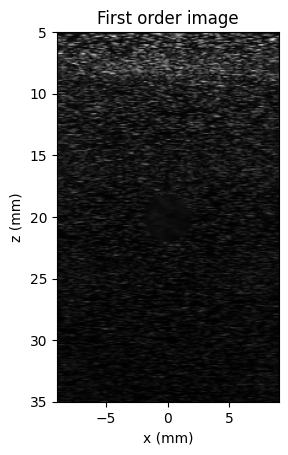

In [4]:
imgs_real = []
for i in range(len(imgs_complex)):
    imgs_real.append(np.abs(imgs_complex[i]))

imgs_real = np.stack(imgs_real, 0)
plt.imshow(imgs_real.mean(axis=0), extent=[x[0]*1e3,x[-1]*1e3,z[-1]*1e3,z[0]*1e3], aspect='equal', cmap="gray")
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("First order image")

The inclusion is barely visible in the first order average reconstruction because it does not show a speckle pattern. That's because it averages over a broad range of speckle patterns as the scatterers move and create changing patterns of constructive vs. destructive interference.

Text(0.5, 1.0, 'Second order image')

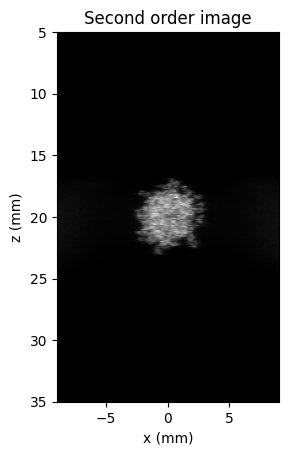

In [5]:
imgs_real = []
for i in range(len(imgs_complex)):
    imgs_real.append(np.abs(imgs_complex[i]))

imgs_real = np.stack(imgs_real, 0)
plt.imshow(imgs_real.std(axis=0), extent=[x[0]*1e3,x[-1]*1e3,z[-1]*1e3,z[0]*1e3], aspect='equal', cmap="gray")
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("Second order image")

The inclusion is clear as day in a second-order reconstruction (Power Doppler), which is done by computing the standard deviation of the reconstructions over time.